# PyCM with Torchbearer

In this example, we show how to use the built in `PyCM` callback to create confusion matrices with torchbearer using the [PyCM library](https://www.pycm.ir/).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed.

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.4.0.dev


## A Simple Model

First we set up the simple CIFAR-10 model from the quickstart (and load the data).

In [2]:
import torch
import torchvision
from torchvision import transforms

from torchbearer.cv_utils import DatasetValidationSplitter

BATCH_SIZE = 128

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

dataset = torchvision.datasets.CIFAR10(root='./data/cifar', train=True, download=True,
                                        transform=transforms.Compose([transforms.ToTensor(), normalize]))
splitter = DatasetValidationSplitter(len(dataset), 0.1)
trainset = splitter.get_train_dataset(dataset)
valset = splitter.get_val_dataset(dataset)

traingen = torch.utils.data.DataLoader(trainset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valgen = torch.utils.data.DataLoader(valset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


testset = torchvision.datasets.CIFAR10(root='./data/cifar', train=False, download=True,
                                       transform=transforms.Compose([transforms.ToTensor(), normalize]))
testgen = torch.utils.data.DataLoader(testset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 16, stride=2, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, stride=2, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride=2, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.classifier = nn.Linear(576, 10)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, 576)
        return self.classifier(x)


model = SimpleModel()

Files already downloaded and verified
Files already downloaded and verified


## Callbacks

We next set up our callbacks, a `PyCM` callback, and a simple `on_end_validation` which will plot our confusion matrix.

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

import torchbearer
from torchbearer.callbacks import PyCM, on_end_validation, CONFUSION_MATRIX

cm = PyCM().on_val()

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function modified to plots the ConfusionMatrix object.
    Normalization can be applied by setting `normalize=True`.
    
    Code Reference : 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    """

    plt_cm = []
    for i in cm.classes :
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    if normalize:
        plt_cm = plt_cm.astype('float') / plt_cm.sum(axis=1)[:, np.newaxis]     
    plt.imshow(plt_cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cm.classes))
    plt.xticks(tick_marks, cm.classes, rotation=45)
    plt.yticks(tick_marks, cm.classes)

    fmt = '.2f' if normalize else 'd'
    thresh = plt_cm.max() / 2.
    for i, j in itertools.product(range(plt_cm.shape[0]), range(plt_cm.shape[1])):
        plt.text(j, i, format(plt_cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if plt_cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predict')

@on_end_validation
def plot(state):
    if state[torchbearer.DATA] is torchbearer.VALIDATION_DATA:
        plt.figure()
        plot_confusion_matrix(state[CONFUSION_MATRIX], normalize=True, title='Confusion Matrix, Epoch ' + str(state[torchbearer.EPOCH]))
        plt.show()

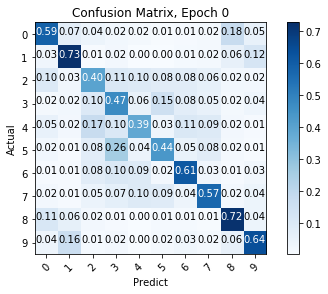

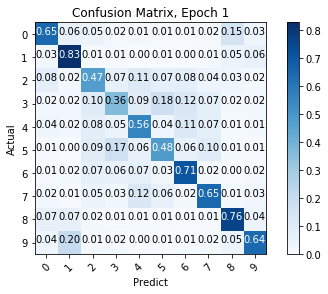

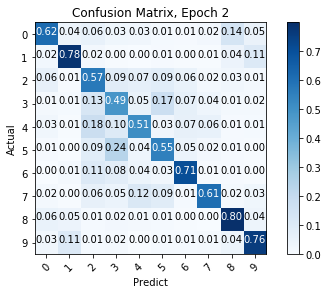

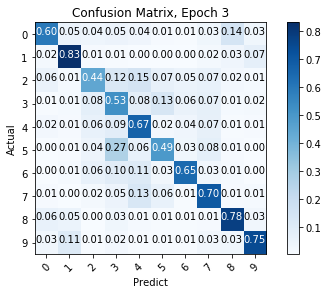

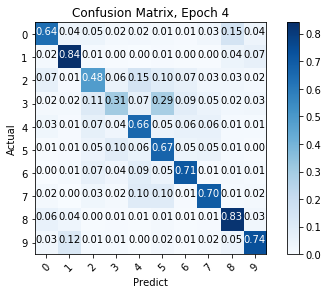

In [4]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = nn.CrossEntropyLoss()

import torchbearer
from torchbearer import Trial

trial = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=[cm, plot]).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history = trial.run(epochs=5, verbose=1)